In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from visualization_utility import plot_data
from NN_model_plots import plot_learning_curve, plot_random, plot_relative_errors, plot_errors_hist
import h5py
import os
import sys

2024-08-22 11:44:15.881965: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 11:44:15.919785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 11:44:15.919800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 11:44:15.920759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 11:44:15.926756: I tensorflow/core/platform/cpu_feature_guar

[NbConvertApp] Converting notebook visualization_utility.ipynb to script
[NbConvertApp] Writing 7407 bytes to visualization_utility.py
[NbConvertApp] Converting notebook NN_model_plots.ipynb to script
[NbConvertApp] Writing 5394 bytes to NN_model_plots.py


In [2]:
print(tf.__version__)

2.15.0


**NOTE:**
- Due to some numerical errors in spherical albedo, it had to be fixed in a separate script ([fix_spherical_albedo](linkki)).
- For this reason, we will not use the [prepare_NN_data](https://github.com/monsieurformule/SummerProject/blob/main/code-files/prepare_NN_data.ipynb) script to preprocess the data like with all the other emulators. 
- Instead, the preprocessing will be performed here in this script.

<h3>Load the data</h3>

In [3]:
# Path to the input data
input_data_path = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/inputs.csv"
# Path to the (corrected) spherical albedo
SA_path = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/spherical_albedo_corrected.h5"

In [4]:
X = pd.read_csv(input_data_path, index_col=0)

In [5]:
X.head(1)

,atmosphere_file,sza,altitude,tau,2e-05,4e-05,6e-05,0.00012,0.00026,0.00062,...,324.0,372.0,426.0,487.0,554.0,628.0,710.0,802.0,902.0,1013.0
0,afglms_Q1_0,25.0,0.0,0.05,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135


In [6]:
# Drop the identifier column
X = X.drop("atmosphere_file", axis=1).values

In [7]:
X.shape

(1728, 53)

In [8]:
def load_HDF5(path: str):
    with h5py.File(name=path, mode="r") as hf:
        data = hf["output_data"][:]
    return data

In [9]:
spherical_albedo = load_HDF5(SA_path)

In [10]:
spherical_albedo.shape

(1728, 235002)

<h3>Preprocess the data</h3>

In [11]:
def preprocess_data(x, y, train_prop: float, val_prop: float, test_prop: float):
    
    ###### Calculate the train, validation, and test sizes #####
    n = x.shape[0]    # number of samples
    num_train_samples = int(n * train_prop)
    num_val_samples = int(n * val_prop)
    num_test_samples = int(n - num_train_samples - num_val_samples)
    
    ###### Data splits ######
    # (X, Y) ==> (train | temp)
    # temp ==> (validation | test)
    X_train, X_temp, Y_train, Y_temp = train_test_split(x, y, train_size=num_train_samples, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=num_test_samples, random_state=42)
    
    ##### Scale the features for numerical stability #####
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X_train)
    scaled_X_train = scaler.transform(X_train)
    scaled_X_val = scaler.transform(X_val)
    scaled_X_test = scaler.transform(X_test)
    
    ##### Convert the data to tf.tensors #####
    scaled_X_train = tf.cast(scaled_X_train, dtype=tf.float32)
    scaled_X_val = tf.cast(scaled_X_val, dtype=tf.float32)
    scaled_X_test = tf.cast(scaled_X_test, dtype=tf.float32)
    Y_train = tf.cast(Y_train, dtype=tf.float32)
    Y_val = tf.cast(Y_val, dtype=tf.float32)
    Y_test = tf.cast(Y_test, dtype=tf.float32)
    
    ##### Add an extra dimension to the input data for convolution #####
    scaled_X_train = tf.expand_dims(scaled_X_train, axis=-1)
    scaled_X_val = tf.expand_dims(scaled_X_val, axis=-1)
    scaled_X_test = tf.expand_dims(scaled_X_test, axis=-1)
    
    data_dict = {
        "scaled_X_train": scaled_X_train,
        "scaled_X_val": scaled_X_val,
        "scaled_X_test": scaled_X_test,
        "Y_train": Y_train,
        "Y_val": Y_val,
        "Y_test": Y_test
    }
    return data_dict

In [12]:
data_dict = preprocess_data(X, spherical_albedo, train_prop=0.8, val_prop=0.1, test_prop=0.1)

2024-08-22 11:44:31.530541: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
scaled_X_train = data_dict["scaled_X_train"]
scaled_X_val = data_dict["scaled_X_val"]
scaled_X_test = data_dict["scaled_X_test"]
Y_train = data_dict["Y_train"]
Y_val = data_dict["Y_val"]
Y_test = data_dict["Y_test"]

In [14]:
print("############### Training data ###############")
print(f"Shape of scaled_X_train: {scaled_X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print()
print("############### Validation data ###############")
print(f"Shape of scaled_X_val: {scaled_X_val.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print()
print("############### Test data ###############")
print(f"Shape of scaled_X_test: {scaled_X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

############### Training data ###############
Shape of scaled_X_train: (1382, 53, 1)
Shape of Y_train: (1382, 235002)

############### Validation data ###############
Shape of scaled_X_val: (172, 53, 1)
Shape of Y_val: (172, 235002)

############### Test data ###############
Shape of scaled_X_test: (174, 53, 1)
Shape of Y_test: (174, 235002)


<h3>Step 4: train the model</h3>

In [15]:
def model(X_train, Y_train, X_val, Y_val, num_epochs: int, batch_size: int):
    """
    Builds, compiles, fits the neural network model. 
    
    Args:
    X -- the input dataset
    Y -- the output dataset
    num_epochs -- the number of epochs
    batch_size -- the batch size
    val_data -- validation data to be used in the training process of the NN
    output_var_name -- name of the output variable that the NN model predicts
    
    Prints:
    - train MSE
    - validation MSE
    
    Returns:
    model -- the fitted neural network model.
    loss_history -- the loss history of the fitted neural network model.
    """
    #tf.random.set_seed(42)
    
    # Architecture of the NN model
    model = Sequential([
        Input(shape=(53, 1)),
        Conv1D(filters=64, kernel_size=3, kernel_initializer=he_normal(), activation="relu"),
        MaxPool1D(pool_size=2, strides=None),
        Conv1D(filters=64, kernel_size=3, kernel_initializer=he_normal(), activation="relu"),
        MaxPool1D(pool_size=2, strides=None),
        Flatten(),
        Dense(units=100, kernel_initializer=he_normal(), activation="relu"),
        Dense(units=100, kernel_initializer=he_normal(), activation="relu"),
        Dense(units=235002, kernel_initializer=glorot_uniform(), activation="linear"),
    ])
    
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                                  factor=0.1, 
                                  patience=3, 
                                  min_lr=0.0009, 
                                  verbose=1)
    
    # This callback will stop the training when there is no improvement in
    # the validation mse for 3 consecutive epochs, and restore the weights 
    # from the epoch with the best value of the monitored quantity (val_loss)
    early_stopping = EarlyStopping(monitor="val_loss",
                                   patience=3,
                                   restore_best_weights=True,
                                   start_from_epoch=0)
    
    # Compile the model
    model.compile(loss=MSE,
                  optimizer=Adam(learning_rate=0.01,
                                 beta_1=0.9,
                                 beta_2=0.999),
                  metrics=["mse"])
    
    # Fit the model
    loss_history = model.fit(X_train, 
                             Y_train, 
                             epochs=num_epochs, 
                             batch_size=batch_size, 
                             validation_data=(X_val, Y_val),
                             callbacks=[reduce_lr, early_stopping])
    
    # Train error
    train_loss, train_mse = model.evaluate(X_train, Y_train)
    
    # Validation error
    val_loss, val_mse = model.evaluate(X_val, Y_val)
    
    print("########################################")
    print(f"Train MSE: {train_mse}")
    print(f"Validation MSE: {val_mse}")
    print("########################################")
    
    return model, loss_history

In [16]:
NN_model, loss_history = model(X_train=scaled_X_train, 
                               Y_train=Y_train,
                               X_val=scaled_X_val,
                               Y_val=Y_val,
                               num_epochs=25,
                               batch_size=32)

Epoch 1/25
44/44 [==============================] - 3s 59ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 1.6341e-04 - val_mse: 1.6341e-04 - lr: 0.0100
Epoch 2/25
44/44 [==============================] - 2s 54ms/step - loss: 1.1679e-04 - mse: 1.1679e-04 - val_loss: 5.1070e-05 - val_mse: 5.1070e-05 - lr: 0.0100
Epoch 3/25
44/44 [==============================] - 2s 53ms/step - loss: 3.6118e-05 - mse: 3.6118e-05 - val_loss: 3.5612e-05 - val_mse: 3.5612e-05 - lr: 0.0100
Epoch 4/25
44/44 [==============================] - 2s 54ms/step - loss: 2.2228e-05 - mse: 2.2228e-05 - val_loss: 1.9822e-05 - val_mse: 1.9822e-05 - lr: 0.0100
Epoch 5/25
43/44 [============================>.] - ETA: 0s - loss: 1.1152e-05 - mse: 1.1152e-05
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
44/44 [==============================] - 2s 56ms/step - loss: 1.1128e-05 - mse: 1.1128e-05 - val_loss: 8.6123e-06 - val_mse: 8.6123e-06 - lr: 0.0100
Epoch 6/25
44/44 [============================

<h3>Evaluate the model on the validation data</h3>

Note that:

- The term 'true' in the plots refers to the output values obtained from libradtran RT model.
- The term 'emulated' refers to the predicted values obtained from the fitted neural network model.

In [17]:
spherical_albedo_preds = NN_model.predict(scaled_X_val)

6/6 [==============================] - 0s 5ms/step


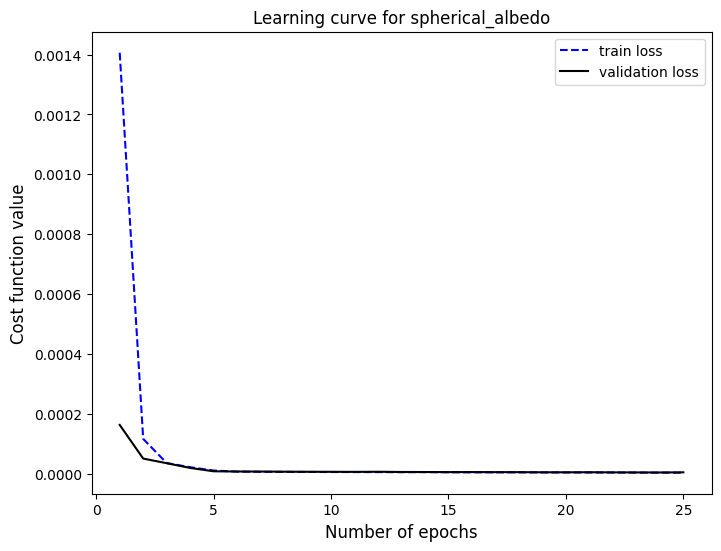

In [18]:
plot_learning_curve(loss_history, "spherical_albedo")

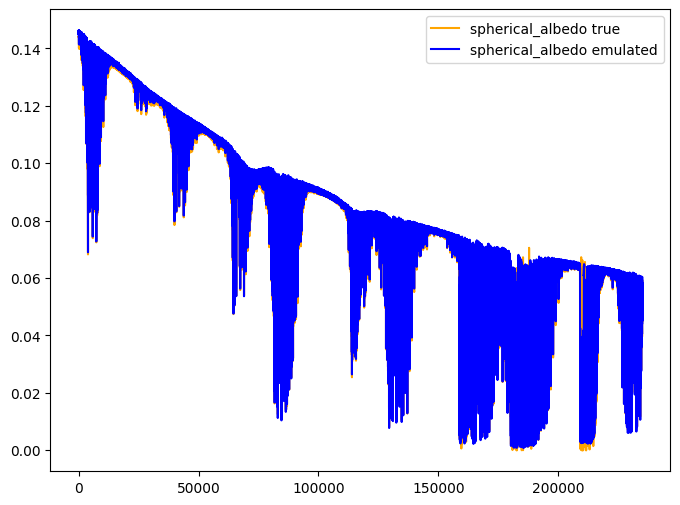

In [19]:
plot_random(spherical_albedo_preds, scaled_X_val, Y_val, "spherical_albedo")

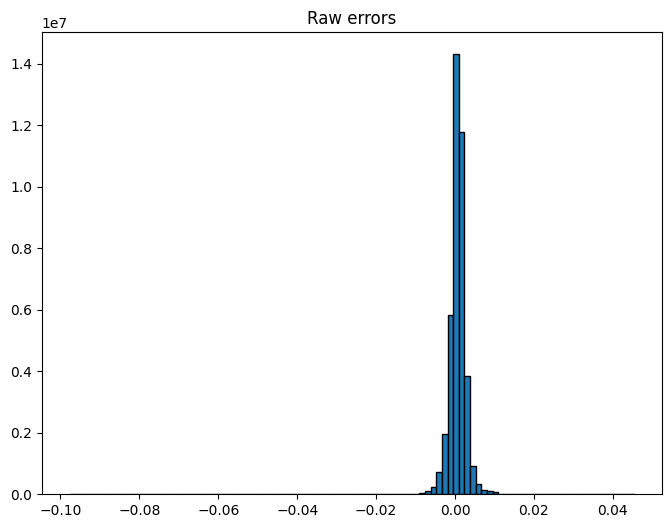

In [20]:
plot_errors_hist(spherical_albedo_preds, scaled_X_val, Y_val)

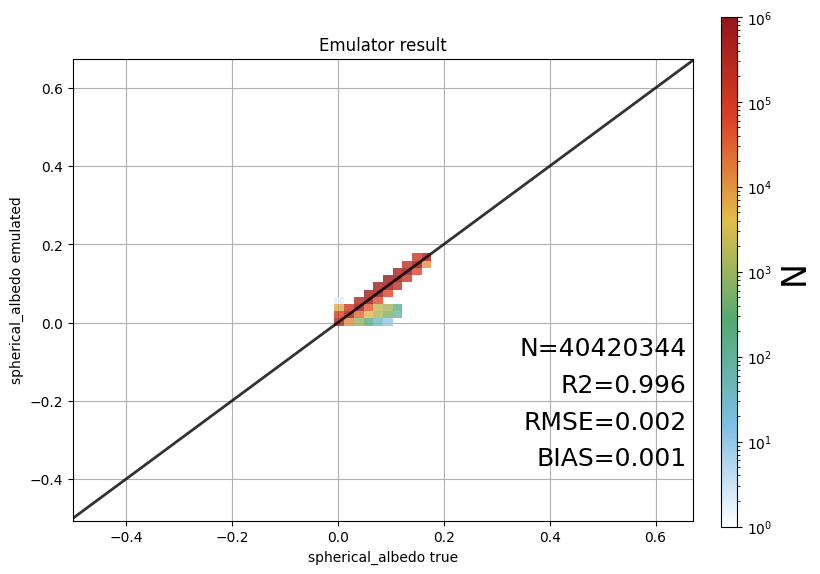

In [21]:
# Plot emulator results vs. true (libradtran RT model) values
plot_data(y_true=Y_val,
          y_pred=spherical_albedo_preds,
          title="Emulator result",
          x_label="spherical_albedo true",
          y_label="spherical_albedo emulated",
          error_bar_on=True,
          save_fig=False,
          fig_name=None)

<h3>Save the predictions</h3>

In [ ]:
def save_HDF5(Y, save_loc, file_name):
    """
    Saves the given NumPy array into the desired location in HDF5 format.
    
    Args:
        Y: NumPy array
        save_loc: the path to the desired saving location
        file_name: name of the saved file
        
    Returns:
        None.
    """
    full_path = save_loc + file_name
    with h5py.File(full_path, "w") as hf:
        hf.create_dataset("output_data", data=Y)

In [ ]:
#save_loc = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/"

In [ ]:
#file_name = "spherical_albedo_preds.h5"
#save_HDF5(Y=spherical_albedo_preds, save_loc=save_loc, file_name=file_name)

<h3>Save the RT model validation data</h3>

In [ ]:
#file_name = "spherical_albedo_val_RT.h5"
#save_HDF5(Y=Y_val, save_loc=save_loc, file_name=file_name)

<h3>Evaluate the model on the test data</h3>

In [23]:
spherical_albedo_preds_test = NN_model.predict(scaled_X_test)

6/6 [==============================] - 0s 5ms/step


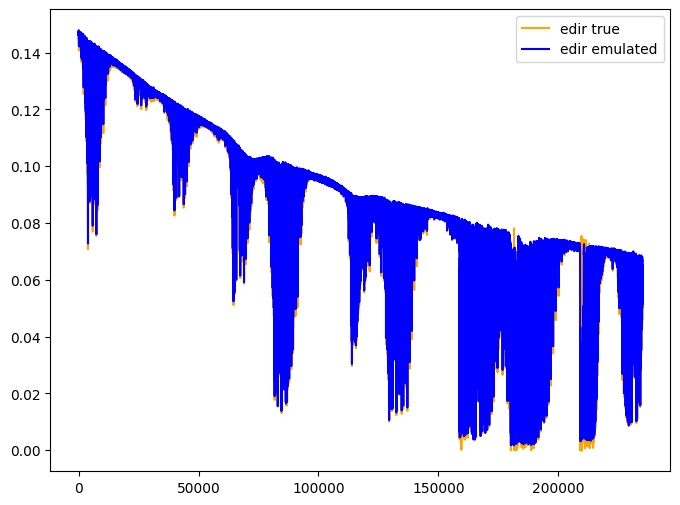

In [24]:
plot_random(spherical_albedo_preds_test, scaled_X_test, Y_test, "edir")

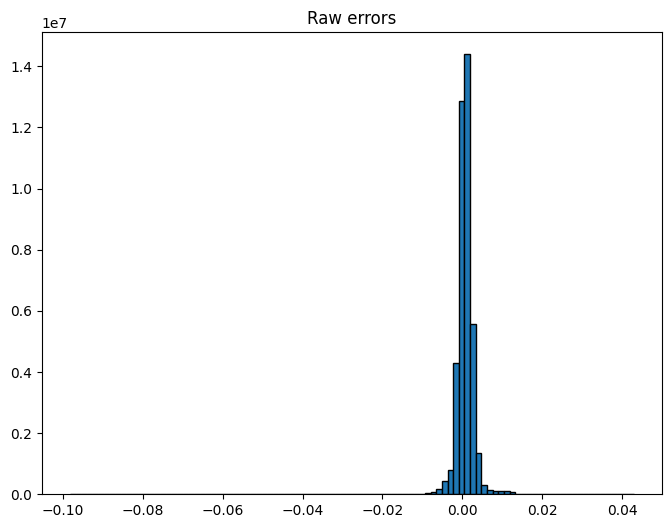

In [25]:
plot_errors_hist(spherical_albedo_preds_test, scaled_X_test, Y_test)

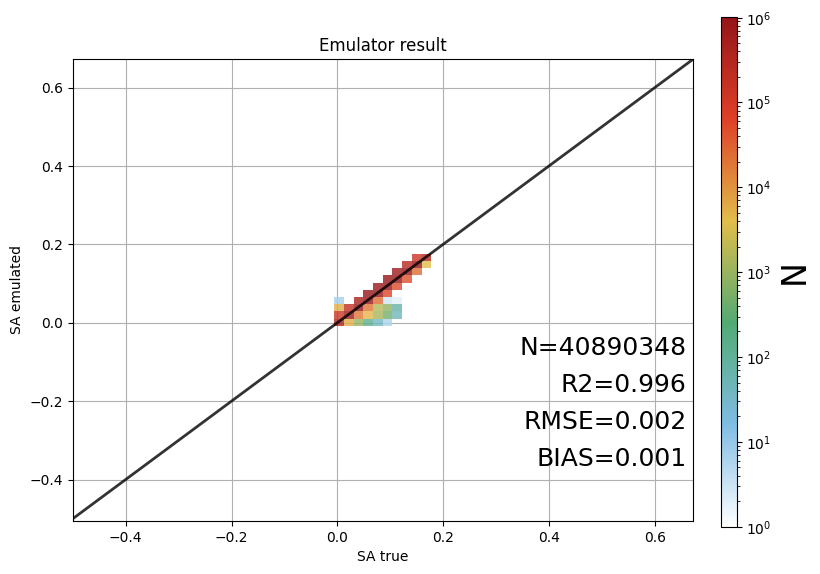

In [26]:
# Plot emulator results vs. true (libradtran RT model) values
plot_data(y_true=Y_test,
          y_pred=spherical_albedo_preds_test,
          title="Emulator result",
          x_label="SA true",
          y_label="SA emulated",
          error_bar_on=True)